# Notes on Chapter 4 of Statistical Rethinking 2nd Edition by Richard McElreath

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
from functools import partial
import math
from math import pi
import warnings

import jax
from jax import numpy as jnp
from jax import scipy as jsp
from jax import random as jr
from jax.scipy import optimize
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow_probability.substrates import jax as tfp
from tensorflow_probability.substrates.jax import distributions as tfd

In [3]:
warnings.resetwarnings()

# JAX's percentile function tries to use FP64 which generates a warning that
# we do not care about here.
warnings.filterwarnings(
    "ignore",
    category=UserWarning, 
    message=r".*Explicitly requested dtype <class 'jax.numpy.\w*64'> " +
        r"requested in \w* is not available.*"
)
# JAX's percentile function also somtimes triggers a deprecation warning from
# sort that we can't fix here.
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning, 
    message=r"The 'kind' argument to sort has no effect, and is deprecated\.",
)

# Loading the rethinking library under Rpy2 triggers a deprecation warning
# that we can't fix here.
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning, 
    message=r"The `source` parameter emit a  deprecation warning since IPython",
)

In [4]:
%load_ext rpy2.ipython

In [5]:
%%R

library(rethinking)

Loading required package: rstan
Loading required package: StanHeaders

rstan version 2.32.6 (Stan version 2.32.2)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)

Loading required package: cmdstanr
This is cmdstanr version 0.7.1
- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr
- Use set_cmdstan_path() to set the path to CmdStan
- Use install_cmdstan() to install CmdStan
Loading required package: parallel
rethinking (Version 2.21)

Attaching package: ‘rethinking’

The following object is masked from ‘package:rstan’:

    stan

The following object is masked from ‘package:stats’:

    rstudent

In addition: Warning messages:
1: In (function (n)  :
  

### 4.1

In [6]:
%%R

pos <- replicate(1000, sum(runif(16, -1, 1)))

In [7]:
pos = jr.uniform(jr.key(42), (1000,16), float, -1, 1).sum(axis=1)

### Figure 4.2

In [8]:
pos.shape

(1000,)

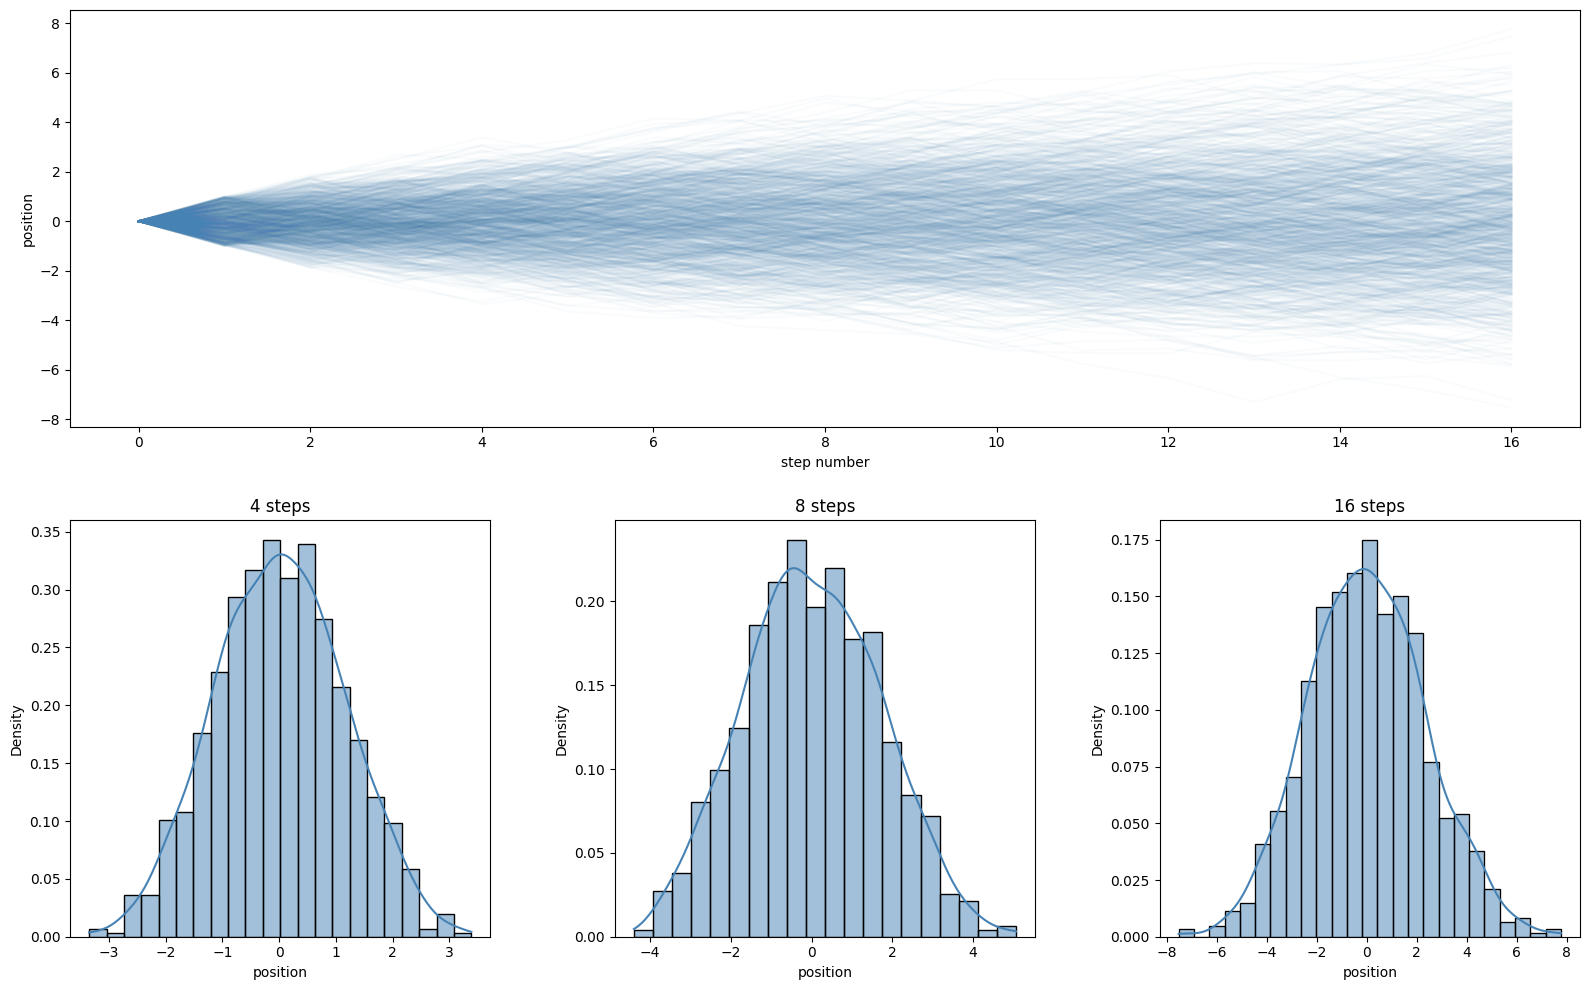

In [9]:
n_steps = 16
n_samples = 1000
pos = jnp.concat([
    jnp.zeros((n_samples,1)),
    jr.uniform(jr.key(42), (n_samples,n_steps), float, -1, 1).cumsum(axis=1)
], axis=1)

plt.figure(figsize=(16,10))

plt.subplot(2,3,(1,3))
plt.plot(jnp.arange(pos.shape[1]), pos.transpose(), 'steelblue', alpha=8/255)
plt.xlabel("step number")
plt.ylabel("position")

plt.subplot(2,3,4)
sns.histplot(pos[:,4], kde=True, stat='density', color='steelblue')
plt.title("4 steps")
plt.xlabel("position")

plt.subplot(2,3,5)
sns.histplot(pos[:,8], kde=True, stat='density', color='steelblue')
plt.title("8 steps")
plt.xlabel("position")

plt.subplot(2,3,6)
sns.histplot(pos[:,16], kde=True, stat='density', color='steelblue')
plt.title("16 steps")
plt.xlabel("position")

plt.tight_layout(h_pad=2, w_pad=4);

### 4.2

In [10]:
%%R

prod(1 + runif(12,0,0.1))

[1] 1.595664


In [11]:
jr.uniform(jr.key(42), (12,), float, 1.0, 1.1).prod()

Array(1.5933064, dtype=float32)

### 4.3

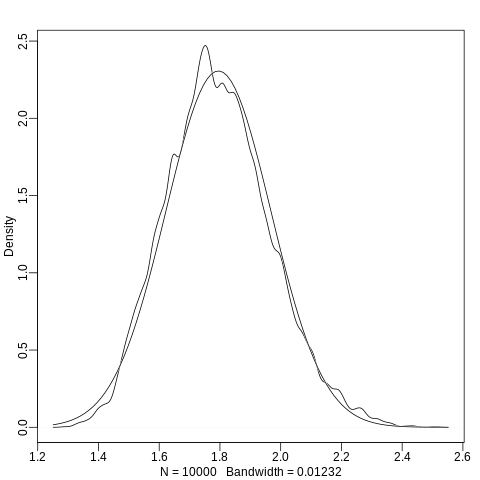

In [12]:
%%R

growth <- replicate(10000, prod(1 + runif(12,0,0.1)))
dens(growth, norm.comp=TRUE)

In [13]:
# add a normal plot for comparison
def plot_normal_comparison(x, **kwargs):
    mu = x.mean()
    sigma = x.std()
    x_ = jnp.linspace(mu - 5*sigma, mu + 5*sigma, 512)
    plt.plot(x_, jsp.stats.norm.pdf(x_, mu, sigma), **kwargs)

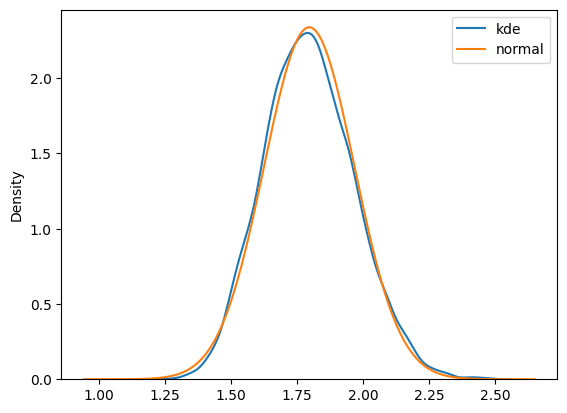

In [14]:
growth = jr.uniform(jr.key(42), (12,10000), float, 1.0, 1.1).prod(axis=0)
sns.kdeplot(growth, label="kde")
plot_normal_comparison(growth, label="normal")
plt.legend()

### 4.4

In [15]:
%%R

big <- replicate(10000, prod(1 + runif(12,0,0.5)))
small <- replicate(10000, prod(1 + runif(12,0,0.01)))

In [16]:
big = jr.uniform(jr.key(81), (12,10000), float, 1.0, 1.5).prod(axis=0)
small = jr.uniform(jr.key(64), (12,10000), float, 1.0, 1.01).prod(axis=0)

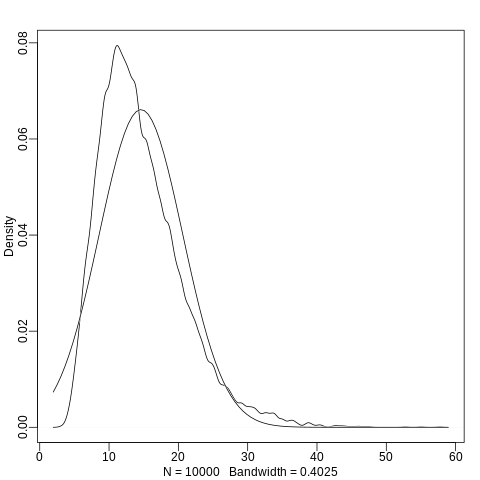

In [17]:
%%R

dens(big, norm.comp=TRUE)

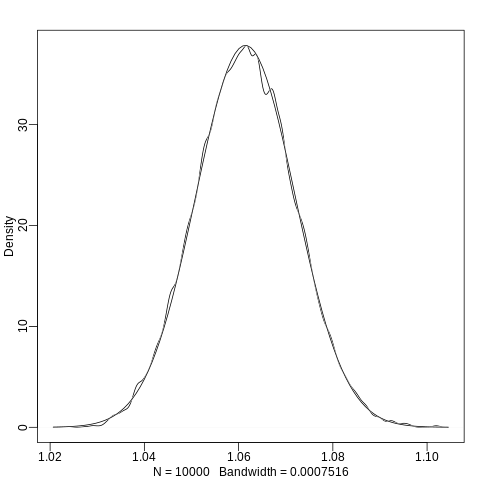

In [18]:
%%R

dens(small, norm.comp=TRUE)

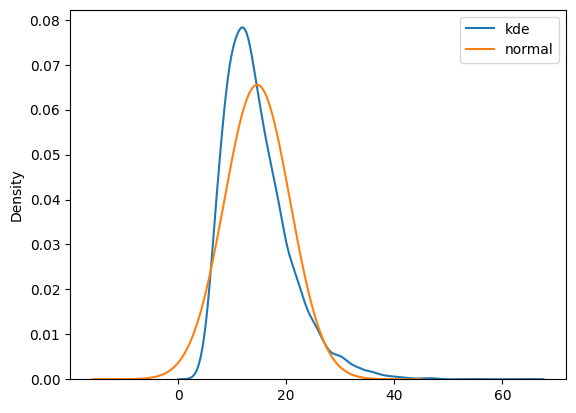

In [19]:
sns.kdeplot(big, label="kde")
plot_normal_comparison(big, label="normal")
plt.legend()

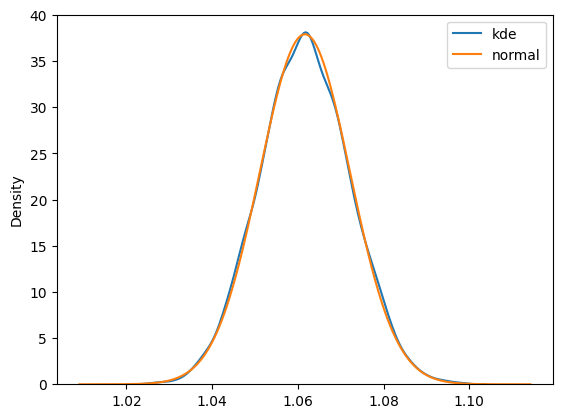

In [20]:
sns.kdeplot(small, label="kde")
plot_normal_comparison(small, label="normal")
plt.legend()

### 4.5

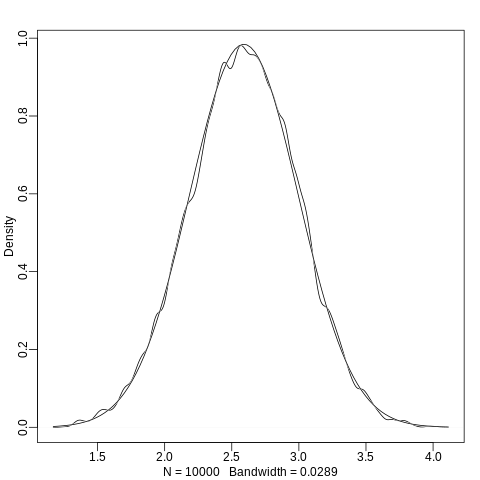

In [21]:
%%R

log.big <- replicate(10000, log(prod(1 + runif(12,0,0.5))))
dens(log.big, norm.comp=TRUE)

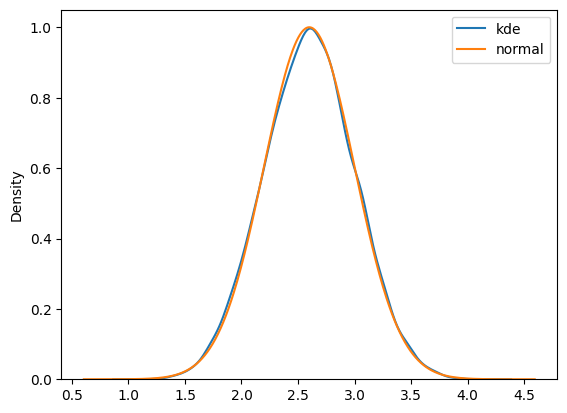

In [22]:
log_big = jnp.log(jr.uniform(jr.key(23), (12,10000), float, 1.0, 1.5).prod(axis=0))
sns.kdeplot(log_big, label="kde")
plot_normal_comparison(log_big, label="normal")
plt.legend()